# NB This second notebook of thesis work is dedicated for working with CNN VGG16 model. All pre-processing and tests of simple algorithms are done in first notebook. This separation was done, because this part of code was used on another machine, with GPU availability


# CNN VGG16 with Pytorch


### Import all libraries

In [1]:
import torch
import torchvision
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import datasets, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Change device to cuda cores (GPU)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Create transformation layer that will resize images to allowed input size of vgg16

In [3]:


# Define a transform to resize images to 224x224 (input size for VGG16)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()  # Convert PIL image to PyTorch tensor
])




### Test cell of Dataloader initialisation

In [4]:
# Assuming 'train_folder' is the name of your training data directory
train_dataset = datasets.ImageFolder('folder/Haar_images/train', transform=transform)
test_dataset = datasets.ImageFolder('folder/Haar_images/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True)


testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False)


### Download and initialise vgg16 model

In [13]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Change last layer of model to output prediction of dataset classes
 Freeze convolution layers to not be trainable

In [14]:
# change the number of classes
vgg16.classifier[6].out_features = 418
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

NameError: name 'vgg16' is not defined

### Validation function, that evaluate model metrics on test data

In [4]:
# validation function

from sklearn.metrics import f1_score, precision_score, recall_score


def validate(model, test_dataloader,criterion):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    targets_list = []
    preds_list = []
    with torch.no_grad():
        for int, data in enumerate(test_dataloader):
            data, target = data[0].to(device), data[1].to(device)
            output = model(data)
            loss = criterion(output, target)

            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == target).sum().item()

            # move targets and preds to cpu and convert to numpy
            targets_list.extend(target.detach().cpu().numpy())
            preds_list.extend(preds.detach().cpu().numpy())

    f1 = f1_score(targets_list, preds_list, average='micro')
    precision = precision_score(targets_list, preds_list, average='micro')
    recall = recall_score(targets_list, preds_list, average='micro')

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)

    return val_loss, val_accuracy, f1, precision, recall


In [5]:
# training function of model, outputs train loss and accuracy to control overfitting
def fit(model, train_dataloader,optimizer,criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    #print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [6]:
# Function that trains vgg16 for N epochs, returns all needed metrics from test data.


def train(model,trainloader,testloader,epoch,optimizer,criterion):
    train_loss , train_accuracy = [], []
    val_loss , val_accuracy = [], []
    for e in range(epoch):
        print(e)
        train_epoch_loss, train_epoch_accuracy = fit(model, trainloader,optimizer,criterion)
        val_epoch_loss, val_epoch_accuracy,val_f1,val_precision,val_recall = validate(model, testloader,criterion)
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)
        print(f"Test Loss: {val_epoch_loss:.4f},Test Acc:{val_epoch_accuracy:.2f}")
    return val_epoch_accuracy,val_f1, val_precision, val_recall

### Another test function do not run

In [39]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(2):
    print(epoch)
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy,val_f1,val_precision,val_recall = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    print(f"Test Loss: {val_epoch_loss:.4f},Test Acc:{val_epoch_accuracy:.2f}")
print(val_f1)
end = time.time()
print((end-start)/60, 'minutes')





0
Test Loss: 0.0308,Test Acc:36.85
1
Test Loss: 0.0311,Test Acc:37.39
0.3738601823708207
0.9237032135327657 minutes


### Funtion that creates on each for loop call new vgg16 model and trains it on new subset data

In [7]:

def pipe(folder,bs,epoch):
    result = pd.DataFrame(columns=["Model","Accuracy","Precision","Recall","F1","Time"])
    for algorithm in os.listdir(folder):

        start = time.time()
        train_path = os.path.join(folder,algorithm,'train')
        test_path = os.path.join(folder,algorithm,'test')
        # Print which algorithm is currently being processed
        print(train_path)
        print(test_path)
        # take dataset folders and transform data with transformation layer. In our case just resize image
        train_dataset = datasets.ImageFolder(train_path, transform=transform)
        test_dataset = datasets.ImageFolder(test_path, transform=transform)
        # Create Dataloader object with determined in function inisialisation batch size
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs)


        testloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs)
        #initialise vgg16 network
        vgg16 = models.vgg16(pretrained=True)


        # optimizer
        optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
        # loss function
        criterion = nn.CrossEntropyLoss()


        # Freeze all the layers
        for param in vgg16.features.parameters():
            param.requires_grad = False

        # Unfreeze the last few convolutional layers so model can focus on features in respect of data
        for layer in [vgg16.features[i] for i in range(19,31)]:
            for param in layer.parameters():
                param.requires_grad = True

        # Replace the last layer to match the number of classes
        vgg16.classifier[6].out_features = 418
        vgg16.to(device)

        accuracy, f1, precision, recall = train(vgg16,trainloader,testloader,epoch,optimizer,criterion)
        end = time.time()
        total = (end - start )/60
        df1 = pd.DataFrame({"Model": algorithm,"Accuracy": accuracy,"Precision":precision,"Recall":recall,"F1":f1,"Time":total},index=[0])
        result = result.append(df1,ignore_index=True)
    return result




In [8]:
# Funtion to save pandas table into csv file

def save_dataframe_to_csv(dataframe, file_name):
    # Save the dataframe to a CSV file
    dataframe.to_csv(file_name, index=False)

In [9]:
folder = "folder"

result = pipe(folder,128,50)

save_dataframe_to_csv(result,"vgg.csv")

folder\Haar_images\train
folder\Haar_images\test


C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Test Loss: 0.0572,Test Acc:3.88
1
Test Loss: 0.0530,Test Acc:7.83
2
Test Loss: 0.0503,Test Acc:7.90
3
Test Loss: 0.0487,Test Acc:7.98
4
Test Loss: 0.0477,Test Acc:8.28
5
Test Loss: 0.0470,Test Acc:8.97
6
Test Loss: 0.0462,Test Acc:9.50
7
Test Loss: 0.0455,Test Acc:9.95
8
Test Loss: 0.0448,Test Acc:11.47
9
Test Loss: 0.0442,Test Acc:11.40
10
Test Loss: 0.0434,Test Acc:11.70
11
Test Loss: 0.0423,Test Acc:14.89
12
Test Loss: 0.0413,Test Acc:16.49
13
Test Loss: 0.0401,Test Acc:19.38
14
Test Loss: 0.0389,Test Acc:21.35
15
Test Loss: 0.0376,Test Acc:23.40
16
Test Loss: 0.0370,Test Acc:24.62
17
Test Loss: 0.0367,Test Acc:24.32
18
Test Loss: 0.0355,Test Acc:25.08
19
Test Loss: 0.0337,Test Acc:27.89
20
Test Loss: 0.0366,Test Acc:22.57
21
Test Loss: 0.0379,Test Acc:26.67
22
Test Loss: 0.0348,Test Acc:28.95
23
Test Loss: 0.0358,Test Acc:28.19
24
Test Loss: 0.0343,Test Acc:29.03
25
Test Loss: 0.0318,Test Acc:32.29
26
Test Loss: 0.0321,Test Acc:34.19
27
Test Loss: 0.0326,Test Acc:35.49
28
Test Lo

C:\Users\Danila\AppData\Local\Temp\ipykernel_16980\1552141526.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(df1,ignore_index=True)
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Test Loss: 0.0578,Test Acc:5.90
1
Test Loss: 0.0534,Test Acc:7.90
2
Test Loss: 0.0503,Test Acc:7.90
3
Test Loss: 0.0491,Test Acc:7.90
4
Test Loss: 0.0479,Test Acc:7.90
5
Test Loss: 0.0472,Test Acc:7.98
6
Test Loss: 0.0468,Test Acc:8.44
7
Test Loss: 0.0463,Test Acc:9.43
8
Test Loss: 0.0461,Test Acc:10.35
9
Test Loss: 0.0455,Test Acc:10.74
10
Test Loss: 0.0448,Test Acc:11.20
11
Test Loss: 0.0442,Test Acc:12.35
12
Test Loss: 0.0434,Test Acc:13.27
13
Test Loss: 0.0426,Test Acc:15.34
14
Test Loss: 0.0419,Test Acc:16.49
15
Test Loss: 0.0410,Test Acc:17.79
16
Test Loss: 0.0399,Test Acc:18.87
17
Test Loss: 0.0388,Test Acc:21.47
18
Test Loss: 0.0378,Test Acc:23.47
19
Test Loss: 0.0371,Test Acc:24.16
20
Test Loss: 0.0368,Test Acc:24.16
21
Test Loss: 0.0363,Test Acc:25.08
22
Test Loss: 0.0363,Test Acc:25.23
23
Test Loss: 0.0383,Test Acc:25.23
24
Test Loss: 0.0365,Test Acc:27.45
25
Test Loss: 0.0349,Test Acc:28.83
26
Test Loss: 0.0354,Test Acc:30.14
27
Test Loss: 0.0363,Test Acc:29.29
28
Test Lo

C:\Users\Danila\AppData\Local\Temp\ipykernel_16980\1552141526.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(df1,ignore_index=True)
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Test Loss: 0.0538,Test Acc:4.10
1
Test Loss: 0.0493,Test Acc:8.12
2
Test Loss: 0.0463,Test Acc:8.12
3
Test Loss: 0.0448,Test Acc:8.12
4
Test Loss: 0.0441,Test Acc:8.12
5
Test Loss: 0.0433,Test Acc:8.20
6
Test Loss: 0.0428,Test Acc:8.99
7
Test Loss: 0.0425,Test Acc:10.17
8
Test Loss: 0.0419,Test Acc:11.04
9
Test Loss: 0.0413,Test Acc:11.83
10
Test Loss: 0.0406,Test Acc:12.54
11
Test Loss: 0.0400,Test Acc:13.56
12
Test Loss: 0.0394,Test Acc:14.75
13
Test Loss: 0.0384,Test Acc:16.96
14
Test Loss: 0.0376,Test Acc:18.53
15
Test Loss: 0.0364,Test Acc:20.03
16
Test Loss: 0.0354,Test Acc:20.74
17
Test Loss: 0.0344,Test Acc:24.13
18
Test Loss: 0.0335,Test Acc:25.24
19
Test Loss: 0.0326,Test Acc:28.15
20
Test Loss: 0.0329,Test Acc:28.39
21
Test Loss: 0.0352,Test Acc:26.03
22
Test Loss: 0.0387,Test Acc:22.16
23
Test Loss: 0.0338,Test Acc:28.31
24
Test Loss: 0.0352,Test Acc:28.39
25
Test Loss: 0.0349,Test Acc:28.31
26
Test Loss: 0.0318,Test Acc:33.12
27
Test Loss: 0.0340,Test Acc:30.76
28
Test L

C:\Users\Danila\AppData\Local\Temp\ipykernel_16980\1552141526.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(df1,ignore_index=True)
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\envs\Thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Test Loss: 0.0573,Test Acc:6.61
1
Test Loss: 0.0527,Test Acc:7.83
2
Test Loss: 0.0503,Test Acc:7.83
3
Test Loss: 0.0487,Test Acc:7.83
4
Test Loss: 0.0474,Test Acc:7.83
5
Test Loss: 0.0465,Test Acc:8.36
6
Test Loss: 0.0459,Test Acc:8.59
7
Test Loss: 0.0452,Test Acc:9.50
8
Test Loss: 0.0446,Test Acc:10.94
9
Test Loss: 0.0440,Test Acc:11.47
10
Test Loss: 0.0433,Test Acc:12.84
11
Test Loss: 0.0422,Test Acc:15.73
12
Test Loss: 0.0414,Test Acc:17.25
13
Test Loss: 0.0402,Test Acc:20.29
14
Test Loss: 0.0388,Test Acc:23.02
15
Test Loss: 0.0376,Test Acc:24.77
16
Test Loss: 0.0362,Test Acc:25.76
17
Test Loss: 0.0350,Test Acc:27.05
18
Test Loss: 0.0339,Test Acc:27.89
19
Test Loss: 0.0337,Test Acc:27.43
20
Test Loss: 0.0342,Test Acc:27.36
21
Test Loss: 0.0337,Test Acc:29.41
22
Test Loss: 0.0333,Test Acc:30.24
23
Test Loss: 0.0340,Test Acc:30.32
24
Test Loss: 0.0299,Test Acc:34.95
25
Test Loss: 0.0293,Test Acc:35.03
26
Test Loss: 0.0304,Test Acc:33.28
27
Test Loss: 0.0308,Test Acc:33.13
28
Test Lo

C:\Users\Danila\AppData\Local\Temp\ipykernel_16980\1552141526.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(df1,ignore_index=True)


### Evaluate each model with
* accuracy
* recall
* precision
* f1-score

# Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
ind = np.arange(4)
width = 0.25


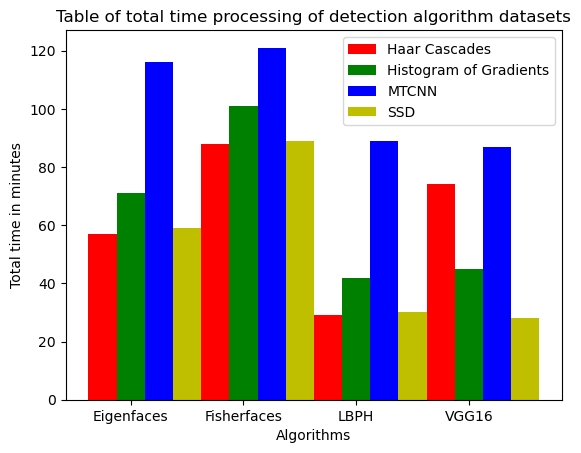

In [64]:
# Total time processing of algorithms

haarvals = [54+3,85+3,26+3,71+3]
haarbar = plt.bar(ind,haarvals,width,color="r")
hogvals = [53+18,83+18,24+18,27+18]
hogbar = plt.bar(ind+width,hogvals,width,color="g")
mtcnnvals = [50+66,55+66,23+66,21+66]
mtcnnbar = plt.bar(ind+width*2,mtcnnvals,width,color="b")
ssdvals = [54+5,84+5,25+5,23+5]
ssdbar = plt.bar(ind+width*3,ssdvals,width,color="y")

plt.xlabel("Algorithms")
plt.ylabel('Total time in minutes')
plt.title("Table of total time processing of detection algorithm datasets")

plt.xticks(ind+width,['Eigenfaces', 'Fisherfaces', 'LBPH','VGG16'])
plt.legend( (haarbar, hogbar, mtcnnbar,ssdbar), ('Haar Cascades', 'Histogram of Gradients', 'MTCNN','SSD') )
#plt.show()
plt.savefig('time.png')


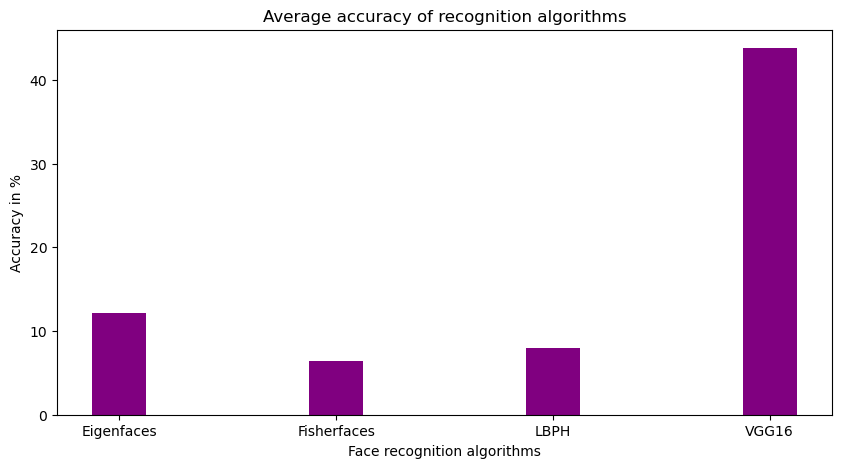

In [65]:
# average accuracy of face recognition

eigen = 12.19
fisher = 6.47
lbph = 7.92
vgg = 43.8

val = [eigen,fisher,lbph,vgg]
lbl = ['Eigenfaces', 'Fisherfaces', 'LBPH','VGG16']

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(lbl, val, color ='purple',
        width = 0.25)

plt.xlabel("Face recognition algorithms")
plt.ylabel("Accuracy in %")
plt.title("Average accuracy of recognition algorithms")
#plt.show()
plt.savefig('avrg_acc_recognition.png')

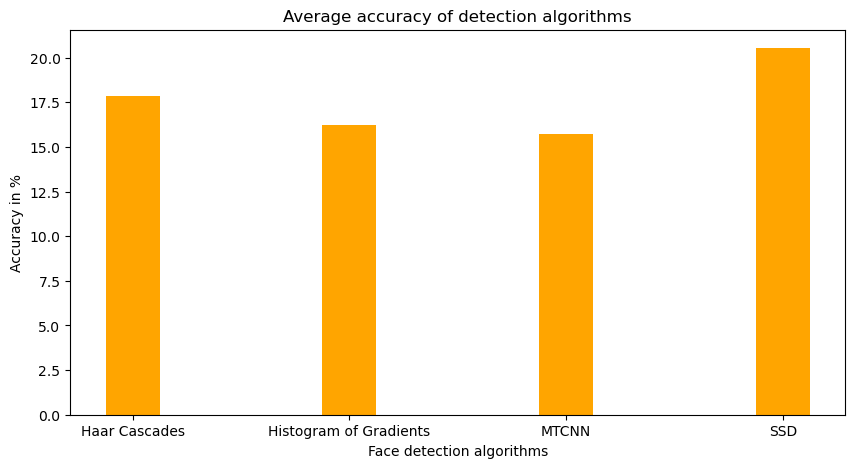

In [66]:
# average accuracy of face detection

haar = 17.86
hog = 16.24
mtcnn = 15.75
ssd = 20.54

val = [haar,hog,mtcnn,ssd]
lbl = ['Haar Cascades', 'Histogram of Gradients', 'MTCNN','SSD']


fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(lbl, val, color ='orange',
        width = 0.25)

plt.xlabel("Face detection algorithms")
plt.ylabel("Accuracy in %")
plt.title("Average accuracy of detection algorithms")
#plt.show()
plt.savefig('avrg_acc_detection.png')

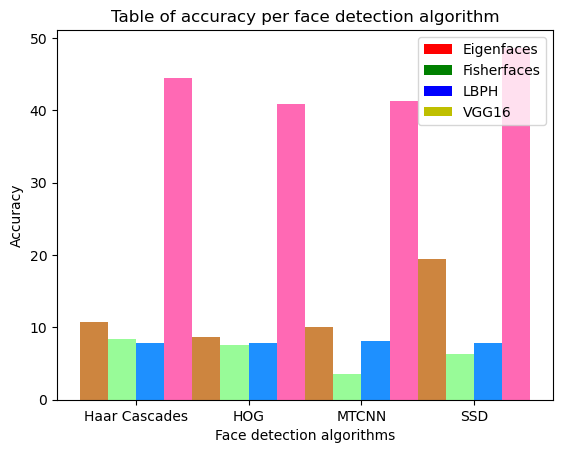

In [67]:
# accuracy by detection algorithms

eigen = [10.71,8.67,10.02,19.38]
eigenbar = plt.bar(ind+width,eigen,width,color="peru")

fisher = [8.43,7.59,3.55,6.31]
fisherbar = plt.bar(ind+width*2,fisher,width,color="palegreen")

lbph = [7.83,7.9,8.12,7.83]
lbphbar = plt.bar(ind+width*3,lbph,width,color="dodgerblue")

vgg = [44.45,40.80,41.32,48.63]
vggbar = plt.bar(ind+width*4,vgg,width,color="hotpink")

plt.xlabel("Face detection algorithms")
plt.ylabel('Accuracy')
plt.title("Table of accuracy per face detection algorithm")

plt.xticks(ind+width*2.5,['Haar Cascades', 'HOG', 'MTCNN','SSD'])
plt.legend( (haarbar, hogbar, mtcnnbar,ssdbar), ('Eigenfaces', 'Fisherfaces', 'LBPH','VGG16') )
#plt.show()
plt.savefig('acc_detection.png')


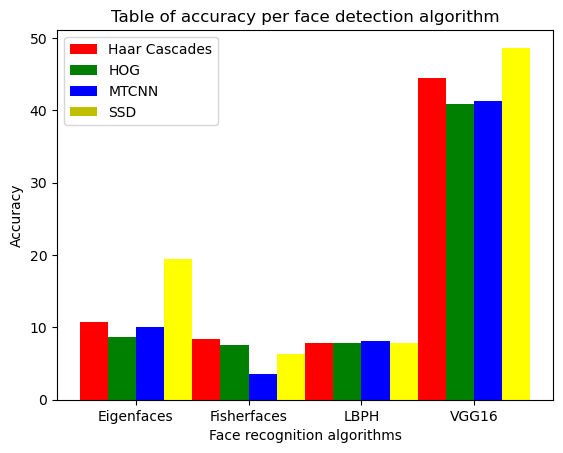

In [68]:
# accuracy by recognition algorithms

eigen = [10.71,8.43,7.83,44.45]
eigenbar = plt.bar(ind+width,eigen,width,color="r")

fisher = [8.67,7.59,7.9,40.80]
fisherbar = plt.bar(ind+width*2,fisher,width,color="g")

lbph = [10.02,3.55,8.12,41.32]
lbphbar = plt.bar(ind+width*3,lbph,width,color="b")

vgg = [19.38,6.31,7.83,48.63]
vggbar = plt.bar(ind+width*4,vgg,width,color="yellow")

plt.xlabel("Face recognition algorithms")
plt.ylabel('Accuracy')
plt.title("Table of accuracy per face detection algorithm")

plt.xticks(ind+width*2.5,['Eigenfaces', 'Fisherfaces', 'LBPH','VGG16'])
plt.legend( (haarbar, hogbar, mtcnnbar,ssdbar), ('Haar Cascades', 'HOG', 'MTCNN','SSD') )
#plt.show()
plt.savefig('acc_recognition.png')

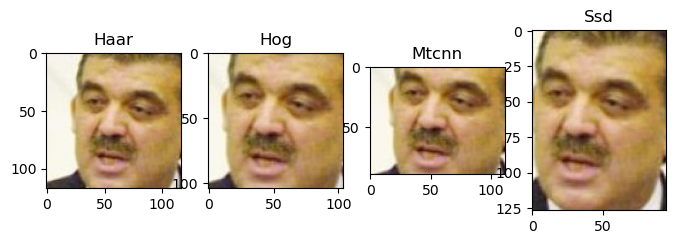

In [87]:
import cv2
# Figure to show difference between face detection algorithms
# folder\Haar_images\train\Abdullah_Gul\Abdullah_Gul_0001.jpg
pictures = ['folder/Haar_images/train/Abdullah_Gul/Abdullah_Gul_0001.jpg','folder/Hog_images/train/Abdullah_Gul/Abdullah_Gul_0001.jpg','folder/Mtcnn_images/train/Abdullah_Gul/Abdullah_Gul_0001.jpg','folder/Ssd_images/train/Abdullah_Gul/Abdullah_Gul_0001.jpg']
rows, cols = 1, 4

images = [cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) for image in pictures]
names = [name.split('/')[1].split("_")[0] for name in pictures]


for i in range(0, len(images), rows * cols):
    fig = plt.figure(figsize=(8, 8))
    for j in range(0, cols * rows):
        fig.add_subplot(rows, cols, j + 1)
        plt.imshow(images[i + j])
        plt.title(f'{names[i+j]}')
    #plt.show()
plt.savefig('all_images.png')
